# Time Series Analysis

This notebook will explore shot and goal data over time. First, we'll inspect the shot and goal distributions throughout the time within games, i.e. how the tendency to shoot and score is distributed through minutes 0-59 of a regulation time NHL game. Next, we will inspect how shot and goal trends have changed over seasons. Has scoring increased over time? Do the types of shots show any trends in play style? Do shot/goal locations show any trends?

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sportypy.surfaces.hockey import NHLRink

PICKLE_PATH = Path("../pickled_data/")

Import relevant data from pickle

In [2]:
game_plays = pd.read_pickle(PICKLE_PATH / "game_plays")
games = pd.read_pickle(PICKLE_PATH / "games")

In [3]:
game_plays.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0


In [4]:
games.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT


We filter by event type of Shot and Goal to get the data we are interested in.

In [3]:
# Filter out shots and goals
shots = game_plays[game_plays['event'] == 'Shot']
goals = game_plays[game_plays['event'] == 'Goal']

### Time in Game

For our first analysis, we can inspect how shots and goals are distributed throughout time in the game. In order to visualize this effectively, we'll need to add a column that shows the total time elapsed in the game. We can calculate this through two existing columns 'period', which tells us the number of the current period (there are 3, 20 minute periods) and 'periodTime', which stores the number of seconds elapsed in the current period. To accomplish this, we simply calculate the base number of seconds for period using $(P - 1) * 1200$ where $P$ is the period and 1200 is the number of seconds in the 20 minute period. So period 1 occupies 0 - 1200 secs (base is 0), period 2 1200-2400 secs (base is 1200), period 3 2400-3600 secs (base is 2400). Then we simply add the seconds elapsed in the current period, giving us total game time elapsed. 

In [4]:
def calculate_total_time(df):
    """Calculates total elapsed game time in seconds, given period and time_elapsed (seconds).

    Args:
        df: Pandas DataFrame with 'period' and 'periodTime' (in seconds) columns.

    Returns:
        Pandas DataFrame with a new 'total_time' column (in seconds).
        Returns the original DataFrame if there's an error.
    """
    df = df.copy() # create a copy of the DataFrame
    
    try:
        
        df['time_elapsed'] = pd.to_numeric(df['periodTime'], errors='coerce')  # Convert to numeric, handle errors

        # Calculate total seconds for each period:
        df['period_seconds'] = (df['period'] - 1) * 1200  # 1200 seconds per period (20 minutes)

        # Calculate total time:
        df['total_time'] = df['period_seconds'] + df['time_elapsed']

        df = df.drop(columns=['period_seconds'])  # Clean up unnecessary column

        return df
    
    except (TypeError, ValueError) as e:
        print(f"Error during time calculation: {e}")
        return df

# add the total time column to the shots dataframe
shots = calculate_total_time(shots)

Next we can plot a heatmap showing the frequency of shots in different minutes of the game. For viewing simplicity, we constrain our results to regular time (0-60 min), and convert seconds to minutes. 

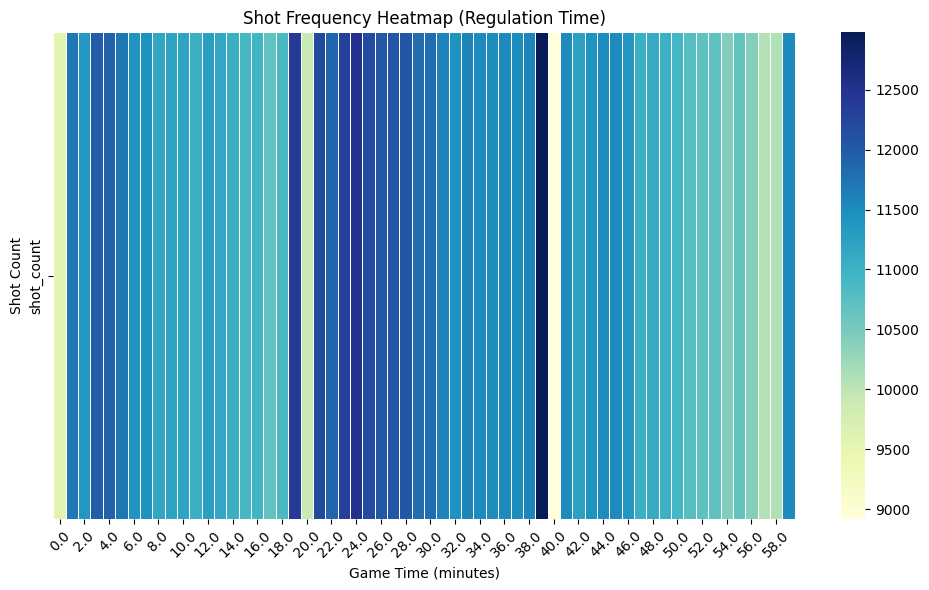

In [6]:
# Heatmap for shot frequency over time of game
# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges 0 - 60 minutes
shots['time_bin'] = pd.cut(shots['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
shot_counts = shots.groupby('time_bin').size().reset_index(name='shot_count')

# Convert time_bin back to seconds for plotting:
shot_counts['time_bin_seconds'] = shot_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
shot_counts['time_bin_minutes'] = shot_counts['time_bin_seconds'] / 60

sns.heatmap(shot_counts.pivot_table(index=None, columns='time_bin_minutes', values='shot_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Heatmap (Regulation Time)")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


The heatmap shows that shots are most likely to occur toward the end of periods, which makes sense, as teams may take higher levels of risk to score when they feel the other team will not have enough time to transition to the other side of the ice and score. Additionally we see that the second period tends to have more shots as a whole than others. In hockey, this is known as the period of the "long change", where each team's bench is closer to the offensive zone than the defensive zone. This means that teams can more easily make subsitutions while on offense than on defense. If a team is possessing the puck for an extended time in the offensive zone, they are more likely to keep tired defenders on the ice, which will result in even more shots.

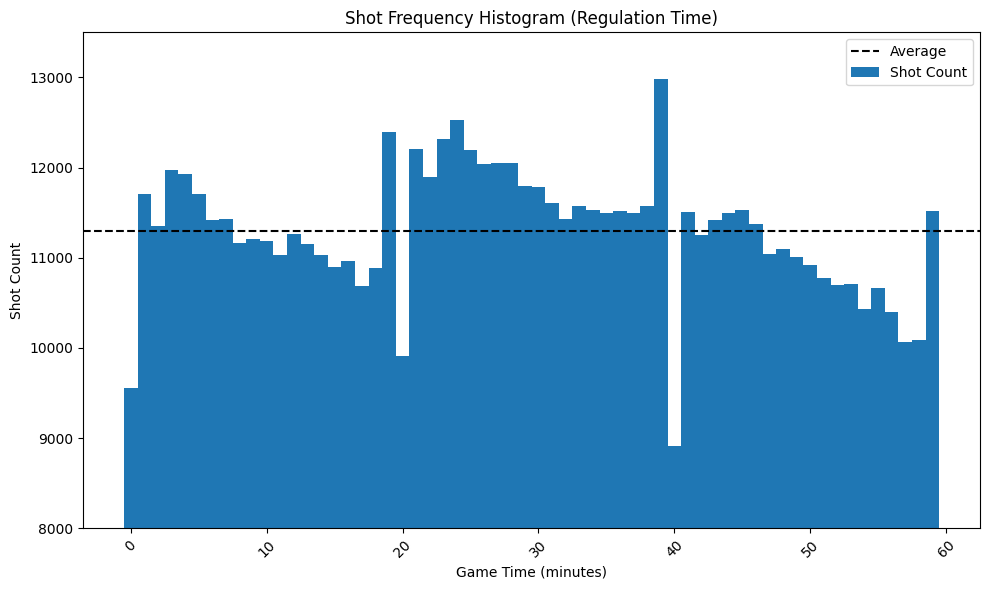

In [15]:
# Histogram of shot count frequency by game time elapsed
plt.figure(figsize=(10, 6))
plt.bar(shot_counts['time_bin_minutes'], shot_counts['shot_count'], width=bin_size/60)  # Use bin_size to determine bar width
plt.axhline(shot_counts["shot_count"].mean(), color='black', linestyle='--')
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Histogram (Regulation Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylim(8000, 13500)
plt.legend(['Average', 'Shot Count'])
plt.tight_layout()
plt.show()

Above, we visualize the same data using a histogram instead. This better captures the variation and allows us to zoom in on a range of interest in the data to highlight that variation

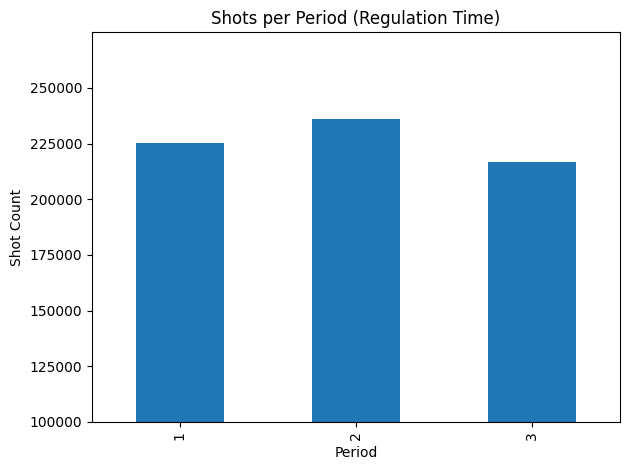

In [20]:
# Simple plot of Shots per period
regulation_shots = shots[shots['period'] <= 3]
regulation_shots.groupby('period')['play_id'].count().plot(kind="bar")
plt.xlabel('Period')
plt.ylabel('Shot Count')
plt.title("Shots per Period (Regulation Time)")
plt.ylim(100000, 275000)
plt.yticks(np.arange(100000, 250001, 25000))
plt.tight_layout()
plt.show()

We can repeat our heatmap and histogram plots for goals, as well.

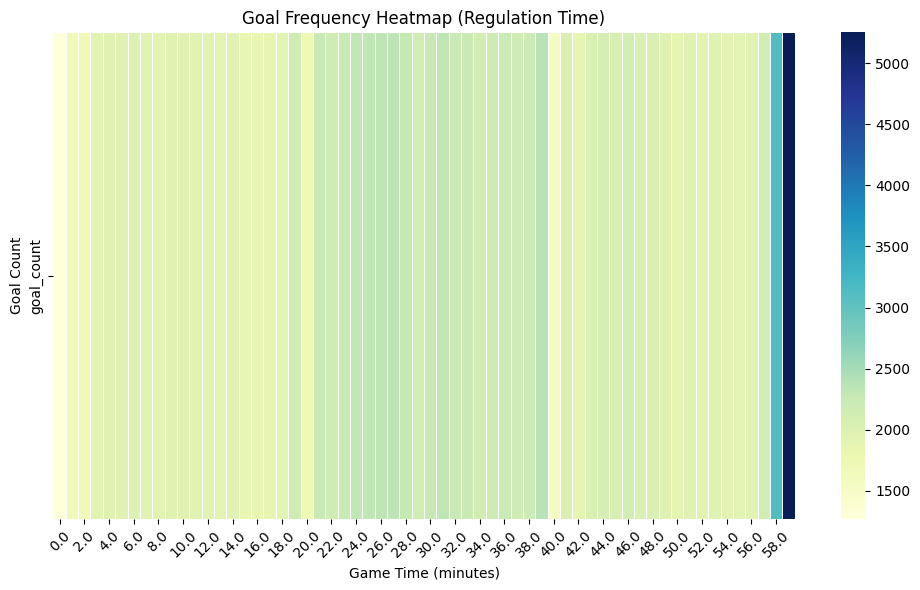

In [9]:
# Add total time column for goals
goals = calculate_total_time(goals)

# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges
goals['time_bin'] = pd.cut(goals['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
goal_counts = goals.groupby('time_bin').size().reset_index(name='goal_count')

# Convert time_bin back to seconds for plotting:
goal_counts['time_bin_seconds'] = goal_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
goal_counts['time_bin_minutes'] = goal_counts['time_bin_seconds'] / 60

sns.heatmap(goal_counts.pivot_table(index=None, columns='time_bin_minutes', values='goal_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Goal Count")
plt.title("Goal Frequency Heatmap (Regulation Time)")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

The distribution for goals is very highly skewed to the final minutes of the game. This is certainly due to the amount of empty net goals that are scored at the end of a game. When a team is only down by 1 or 2 goals, it behooves them to pull their goaltender from the net, allowing them to place an extra skater on the ice to play offense and attempt to even up the score. There is no penalty for losing by more goals, but there is benefit to tying the game and proceeding to overtime, or potentially winning the game in regulation. This skews the number of goals scored to the end of the 3rd period heavily

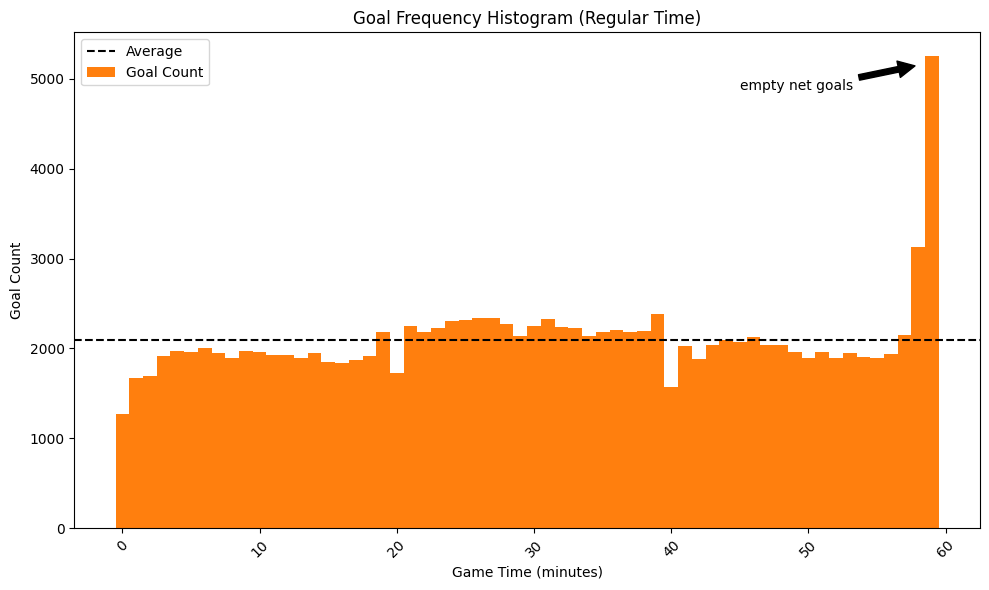

In [16]:
# Histogram of shot count frequency by game time elapsed
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(goal_counts['time_bin_minutes'], goal_counts['goal_count'], width=bin_size/60, color="tab:orange")  # Use bin_size to determine bar width
plt.axhline(goal_counts["goal_count"].mean(), color='black', linestyle='--')
ax.annotate("empty net goals", xy=(58, 5150), xytext=(45, 5000), va="top", ha="left", arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel("Game Time (minutes)")
plt.ylabel("Goal Count")
plt.title("Goal Frequency Histogram (Regular Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.legend(['Average', 'Goal Count'])
plt.tight_layout()
plt.show()

The histogram in this case is preferenable because we do not "wash out" data with the high frequency occurring at the end of the game. We can still see the variation in goal scoring throughout the game. Aside from the spike in goals at the end of the game, we see similar trends to shots, where there are more goals scored overall in the second period, and goal scoring is more common at the ends of periods.

### Variation through Seasons

To add the season data, we must first merge in the season column from games dataframe.

In [17]:
game_plays = pd.merge(game_plays, games[['game_id', 'season']], how="left", on="game_id")

In [18]:
game_plays.dtypes

play_id                 object
game_id                  int64
team_id_for            float64
team_id_against        float64
event                   object
secondaryType           object
x                      float64
y                      float64
period                   int64
periodType              object
periodTime               int64
periodTimeRemaining    float64
dateTime                object
goals_away               int64
goals_home               int64
description             object
st_x                   float64
st_y                   float64
season                   int64
dtype: object

To simplify things and make them a bit cleaner, let's change the season data to align to the year end for each season. This will also allow us to filter a bit easier (ie with 'season' > 2010, for example)

In [19]:
season_replacements = {
    20002001: 2001, 
    20012002: 2002,
    20022003: 2003, 
    20032004: 2004, 
    20052006: 2006,
    20062007: 2007,
    20072008: 2008, 
    20082009: 2009, 
    20092010: 2010,
    20102011: 2011,
    20112012: 2012,
    20122013: 2013, 
    20132014: 2014,
    20142015: 2015,
    20152016: 2016,
    20162017: 2017, 
    20172018: 2018,
    20182019: 2019,
    20192020: 2020
}

game_plays['season'] = game_plays['season'].replace(season_replacements)

In [20]:
shots = game_plays.loc[game_plays['event'] == 'Shot']

### Shot trends

Now that we have our season data, we can take a look at trends in shot totals. Below, we filter to years after 2010, as the years preceding are outliers and have relatively few shots recorded, and only the counts for goals.

In [21]:
# filter to years after 2010 due to missing data
total_shots_after_2010 = shots[shots['season'] > 2010]

# create a function for trendline
df = total_shots_after_2010.groupby('season')['play_id'].count().reset_index()
z = np.polyfit(df['season'], df['play_id'], 1)  # 1 for linear, 2 for quadratic, etc.
p = np.poly1d(z)

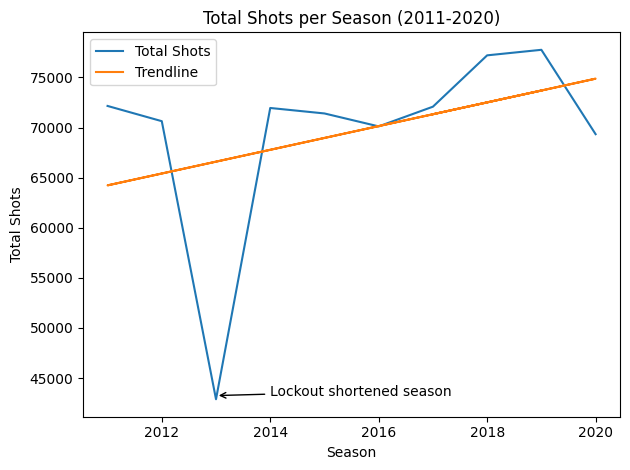

In [24]:
# create plot with shots data and trendline
ax = total_shots_after_2010.groupby('season')['play_id'].count().plot(kind="line")
ax.annotate("Lockout shortened season", xy=(2013, 43250), xytext=(2014, 43250), arrowprops=dict(arrowstyle='->'))
plt.plot(total_shots_after_2010['season'], p(total_shots_after_2010['season']))
plt.xlabel('Season')
plt.ylabel('Total Shots')
plt.title('Total Shots per Season (2011-2020)')
plt.legend(['Total Shots', 'Trendline'])
plt.tight_layout()
plt.show()

We have one outlier season where only about half the season was played due to a lockout. We see that shooting is up in general. This suggests an increased pace of play in more recent years. Next we can take a look at the difference in counts by shot type for each season.

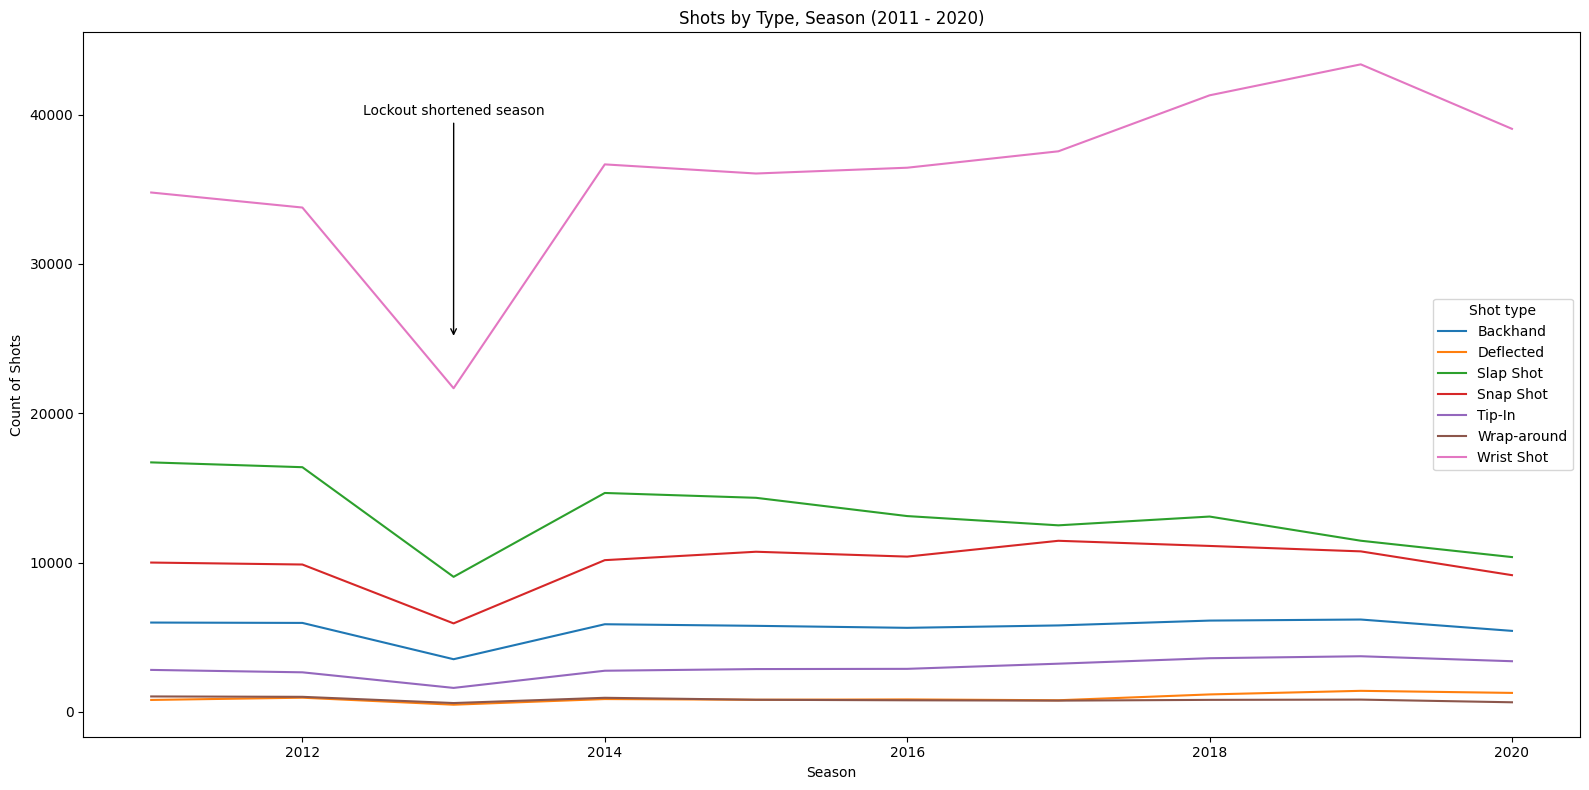

In [ ]:
# create a plot of shot type counts for each season
ax = total_shots_after_2010.groupby(['season', 'secondaryType'])['play_id'].count().unstack().plot(kind="line", figsize=(16, 8))
ax.annotate("Lockout shortened season", xy=(2013, 25000), xytext=(2012.4, 40000), arrowprops=dict(arrowstyle='->'))
plt.title('Shots by Type, Season (2011 - 2020)')
plt.xlabel('Season')
plt.ylabel('Count of Shots')
plt.legend(title="Shot type")
plt.tight_layout()
plt.show()

We see that Slap shots have decreased while Wrist shots have increased. Snap shots show a small trend upward, but a decline in recent years. It might be more illuminating to take a look at shot types as a percentage of the total shots rather than raw counts, this may better highlight trends in greater share with the adjusted scale it will provide

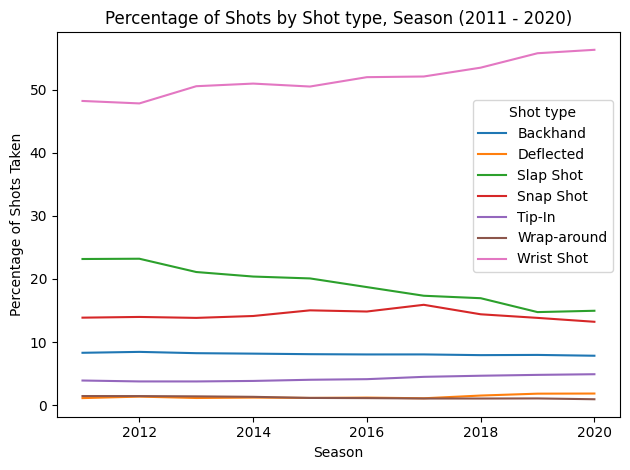

In [49]:
# Group by season and shot type, count occurrences
grouped_shots = total_shots_after_2010.groupby(['season', 'secondaryType']).size().unstack(fill_value=0)

# Calculate percentages within each year
grouped_shots = grouped_shots.div(grouped_shots.sum(axis=1), axis=0) * 100

ax = grouped_shots.plot(kind="line")
plt.title('Percentage of Shots by Shot type, Season (2011 - 2020)')
plt.xlabel('Season')
plt.ylabel('Percentage of Shots Taken')
plt.legend(title="Shot type", bbox_to_anchor=(1.0, 0.6), loc="right")
plt.tight_layout()
plt.show()

This plot better shows that wrist shots have markedly increased, taking over share from snap and slap shots. Other shot types remain mostly flat.

### Goal Trends

Next, we can repeat a similar analysis for goals. Note we don't have to constrain the seasons for raw goal counts, but we will for shot types, as that stat was not reliably tracked until 2011.

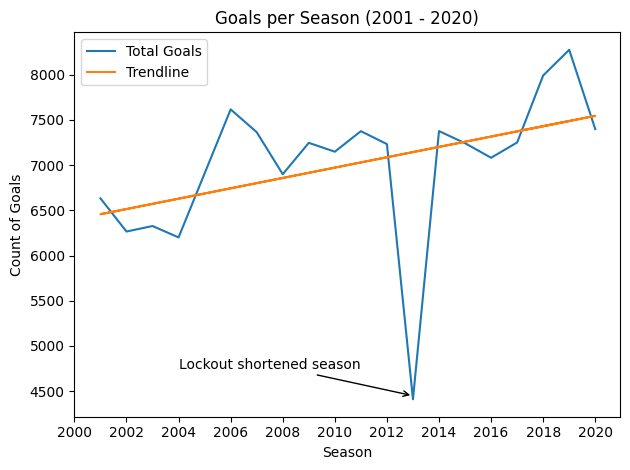

In [25]:
# filter to goals
goals = game_plays.loc[game_plays['event'] == 'Goal']

# create a function to plot the trendline
df = goals.groupby('season')['play_id'].count().reset_index()
z = np.polyfit(df['season'], df['play_id'], 1)  # 1 for linear, 2 for quadratic, etc.
p = np.poly1d(z)

# Create a plot with goals data and trendline
ax = goals.groupby('season')['play_id'].count().plot(kind="line") # plot goals data
ax.annotate("Lockout shortened season", xy=(2013, 4450), xytext=(2004, 4750), arrowprops=dict(arrowstyle='->'))
plt.plot(goals['season'], p(goals['season']))
plt.xlabel('Season')
plt.ylabel('Count of Goals')
plt.title("Goals per Season (2001 - 2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.legend(['Total Goals', 'Trendline'])
plt.tight_layout()
plt.show()

As expected by the general trend upward we saw in shots, goals are also increasing modestly over time. This tells us that games are moving toward higher scores in recent years, and likely a higher pace of play

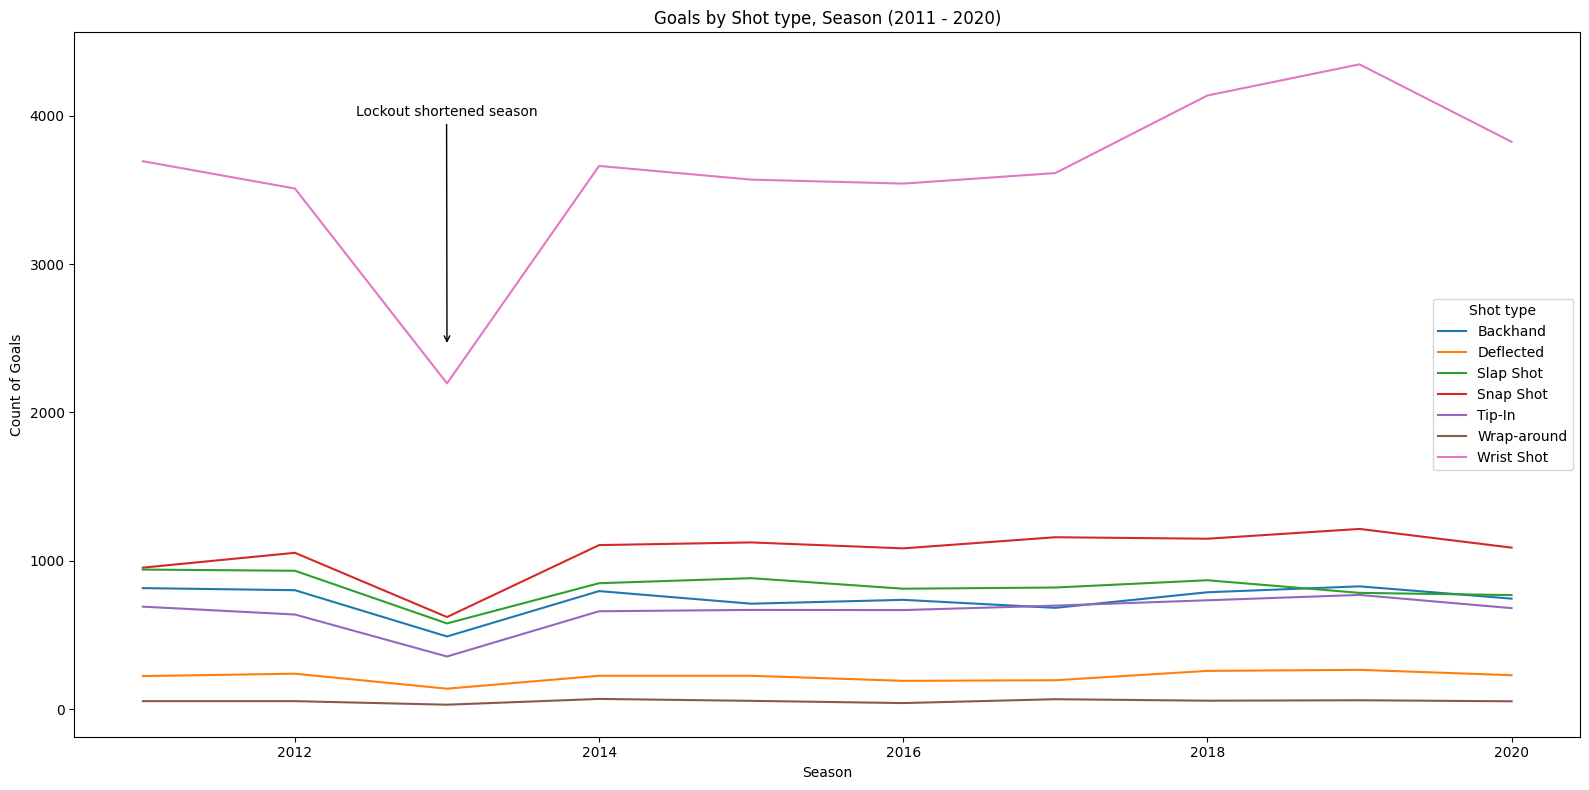

In [48]:
goals_after_2010 = goals[goals['season'] > 2010]
ax = goals_after_2010.groupby(['season', 'secondaryType'])['play_id'].count().unstack().plot(kind="line", figsize=(16, 8))
ax.annotate("Lockout shortened season", xy=(2013, 2450), xytext=(2012.4, 4000), arrowprops=dict(arrowstyle='->'))
plt.title('Goals by Shot type, Season (2011 - 2020)')
plt.xlabel('Season')
plt.ylabel('Count of Goals')
plt.legend(title="Shot type")
plt.tight_layout()
plt.show()

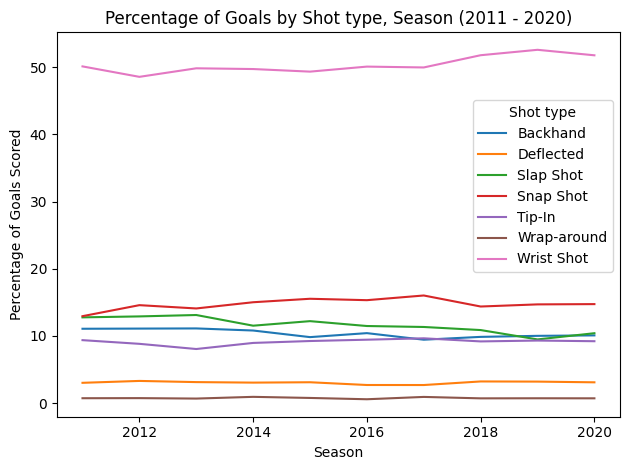

In [47]:
goals_after_2010 = goals[goals['season'] > 2010]

# Group by season and shot type, count occurrences
grouped_goals = goals_after_2010.groupby(['season', 'secondaryType']).size().unstack(fill_value=0)

# Calculate percentages within each year
grouped_goals = grouped_goals.div(grouped_goals.sum(axis=1), axis=0) * 100

ax = grouped_goals.plot(kind="line")
plt.title('Percentage of Goals by Shot type, Season (2011 - 2020)')
plt.xlabel('Season')
plt.ylabel('Percentage of Goals Scored')
plt.legend(title="Shot type", bbox_to_anchor=(1.0, 0.6), loc="right")
plt.tight_layout()
plt.show()

As with shots, we see similar trends in the shot types of goals. However, they are far less pronounced. We see more goals coming from wrist shots and less coming from slap shots. 

### Location Density

We can repeat x and y coordinate correction we performed in the baseline analysis to set ourselves up to plot the location density over all seasons. For these plots, we will constrain ourselves to seasons after 2010, as we have already observed that is when data collection became more reliable.

In [11]:
# Add count columns for counting goals and shots, to be used in density based visualizations later on.
game_plays['goal'] = (game_plays['event'] == "Goal").astype(int)
game_plays['shot'] = (game_plays['event'] == "Shot").astype(int)

# Correct the x and y coordinates to occupy only one side of the ice
game_plays['xC'] = np.abs(game_plays['x'])
game_plays['yC'] = game_plays['y'] * np.sign(game_plays['x'])

# filter for goals and missing coordinates, season after 2010
goals = game_plays.loc[
    ~game_plays["xC"].isna() &
    ~game_plays["yC"].isna() &
    (game_plays['event'].isin(["Goal"])) &
    (game_plays['season'] > 2010)
]
# keep only columns we need for performance in drawing density plots
goals = goals[['xC', 'yC', 'goal','season', 'secondaryType']]

# repeat for shots
# filter for shots and missing coordinates, season after 2010
shots = game_plays.loc[
    ~game_plays["xC"].isna() &
    ~game_plays["yC"].isna() &
    (game_plays['event'].isin(["Shot"])) &
    (game_plays['season'] > 2010)
]
# keep only columns we need for performance in drawing density plots
shots = shots[['xC', 'yC', 'shot', 'season', 'secondaryType']]

In [12]:
seasons = sorted(list(shots['season'].unique()))

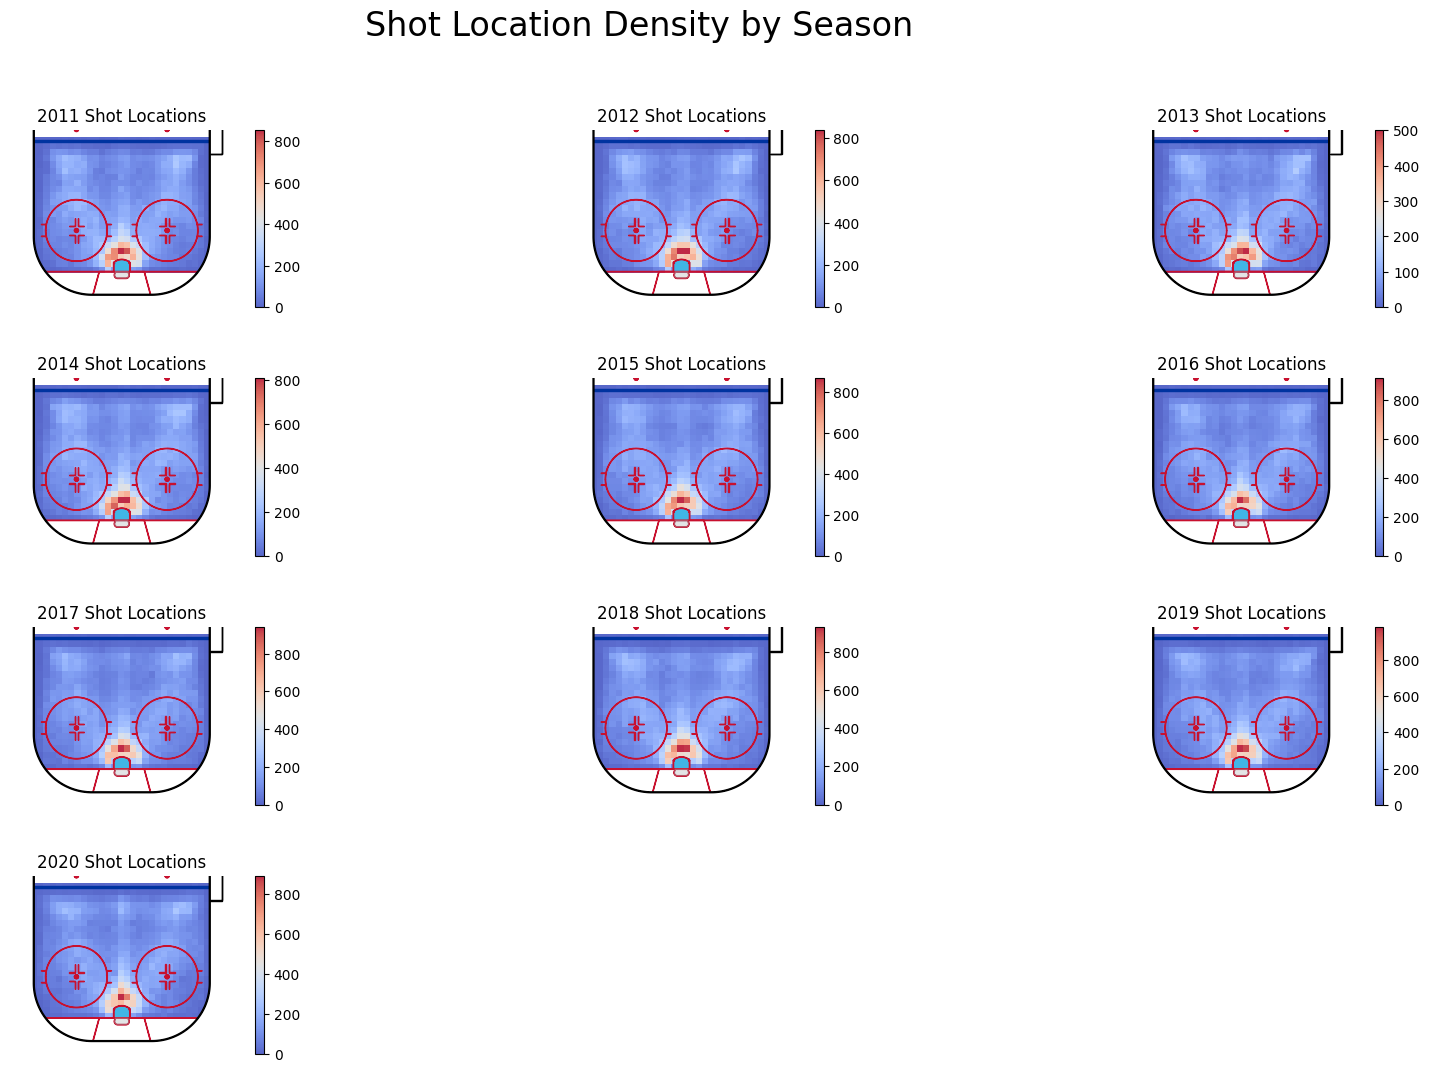

In [14]:
nhl = NHLRink()
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 12),  
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# Only 10 subplots are needed, remove two from the bottom right
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,1])
axes = axes.flatten()[:10]

for i, ax in enumerate(axes):
    # view the shot type we are focused on this loop, axes and shot_types are of same length so we can use i to access
    filtered_shots = shots[shots['season'] == seasons[i]]
    
    # display offensive zone where goal is on bottom of image
    nhl.draw(ax, display_range="ozone", rotation=270) 
    
    # plot the heatmap
    heat = nhl.heatmap(
    filtered_shots["xC"],
    filtered_shots["yC"],
    values = filtered_shots["shot"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3, 
    alpha=0.85
    )
    plt.colorbar(heat, ax=ax) # add a colorbar
    ax.set_title(f"{seasons[i]} Shot Locations") # title the axes
    
fig.suptitle("Shot Location Density by Season", fontsize=24)
plt.show()

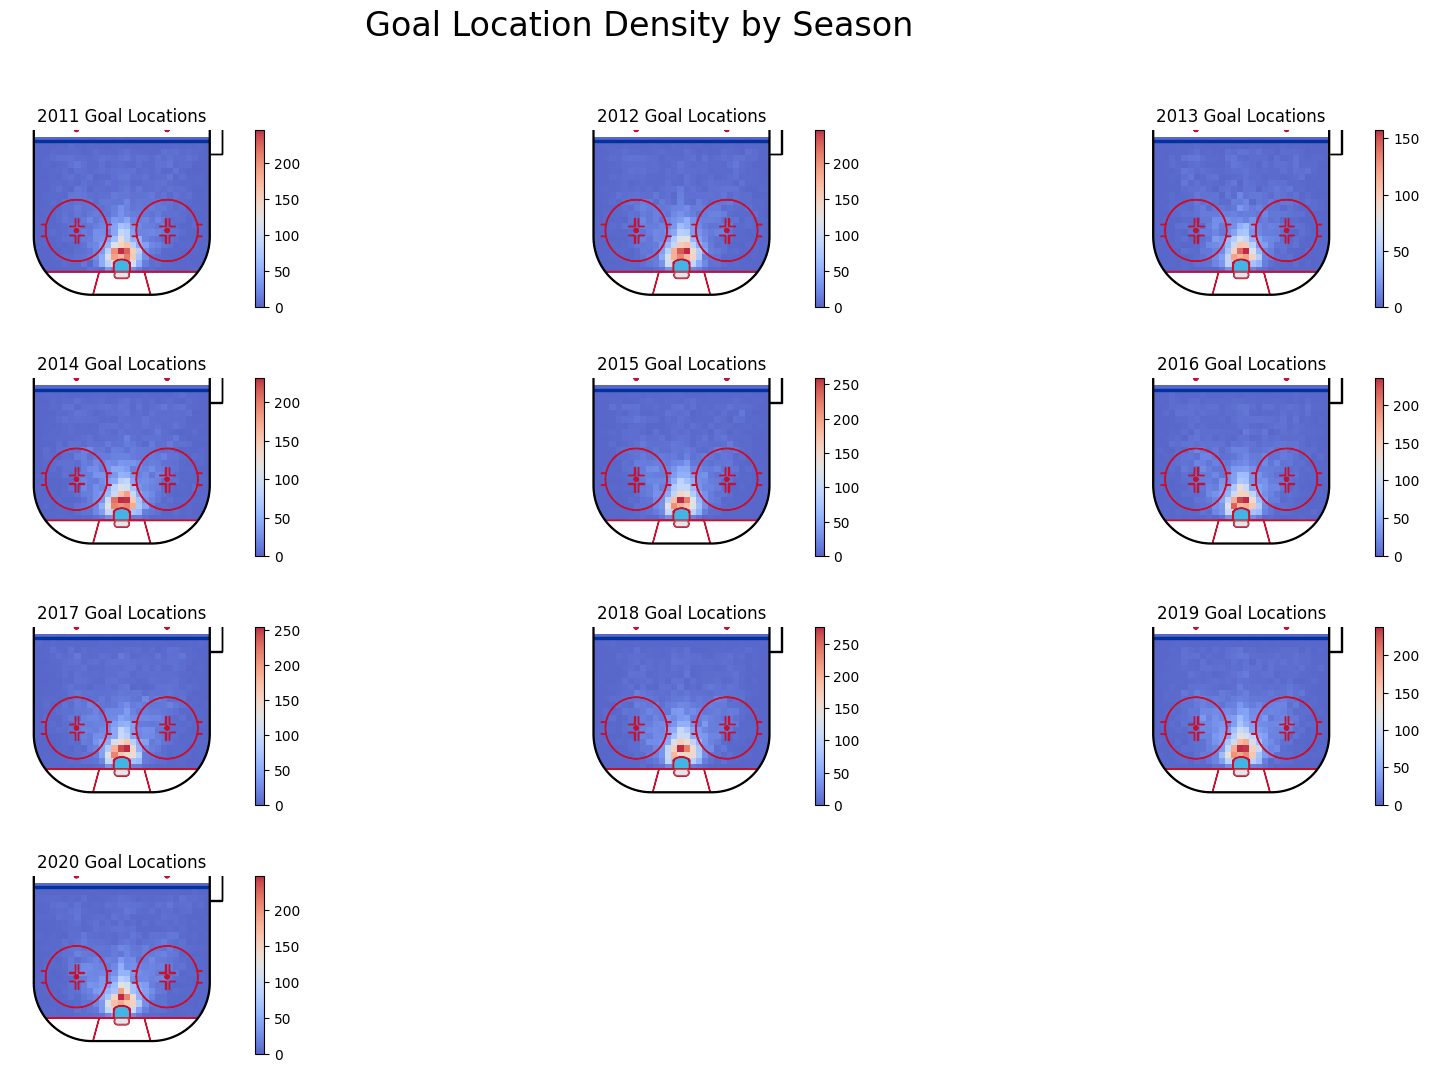

In [15]:
nhl = NHLRink()
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 12),  
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# Only 10 subplots are needed, remove two from the bottom right
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,1])
axes = axes.flatten()[:10]

for i, ax in enumerate(axes):
    # view the shot type we are focused on this loop, axes and shot_types are of same length so we can use i to access
    filtered_goals = goals[goals['season'] == seasons[i]]
    
    # display offensive zone where goal is on bottom of image
    nhl.draw(ax, display_range="ozone", rotation=270) 
    
    # plot the heatmap
    heat = nhl.heatmap(
    filtered_goals["xC"],
    filtered_goals["yC"],
    values = filtered_goals["goal"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3, 
    alpha=0.85
    )
    plt.colorbar(heat, ax=ax) # add a colorbar
    ax.set_title(f"{seasons[i]} Goal Locations") # title the axes
    
fig.suptitle("Goal Location Density by Season", fontsize=24)
plt.show()